In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../../..")
from analysis_functions import *

In [2]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [3]:
component_num = 2

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error


# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = DecisionTreeRegressor(
    random_state=RANDOM_STATE, max_depth=10, min_samples_split=2
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = root_mean_squared_error(cur_y_test, cur_y_pred)
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = root_mean_squared_error(cur_y_train, cur_y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")

RMSE test: 13.38
RMSE train: 12.53


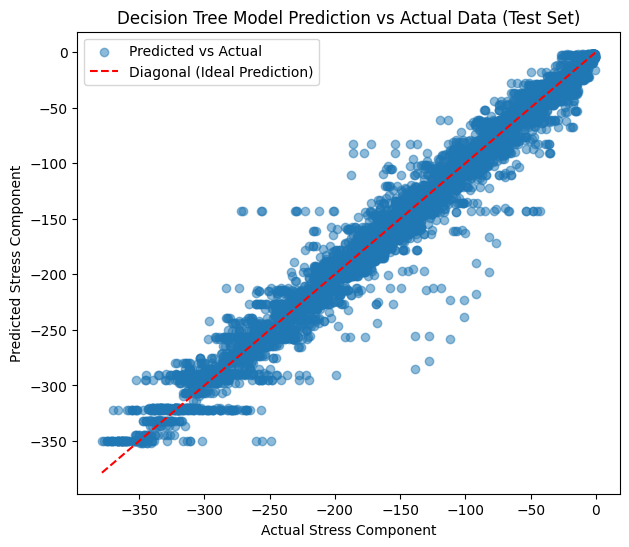

In [6]:
# Plotting the results on the test set
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Decision Tree Model Prediction vs Actual Data (Test Set)")
plt.legend()
plt.show()

## Добавляю кросс-валидацию

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score


n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)


def do_optuna_for_tree(X, y, n_trials=200, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_decision_tree_val(trial):
        max_depth = trial.suggest_int("max_depth", 1, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 32)

        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = DecisionTreeRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = (
            val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6
        )  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_decision_tree_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value


# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_tree(X, y, n_splits=n_splits)
# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = root_mean_squared_error(cur_y_test, cur_y_pred)
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_test)
rmse_train = root_mean_squared_error(cur_y_test, cur_y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")


[I 2025-05-19 03:41:43,266] A new study created in memory with name: no-name-cf07a883-84ac-4dfc-a531-aa97dcbc78dc
[I 2025-05-19 03:41:43,367] Trial 1 finished with value: 66.40743061273606 and parameters: {'max_depth': 1, 'min_samples_split': 12}. Best is trial 1 with value: 66.40743061273606.
[I 2025-05-19 03:41:43,378] Trial 2 finished with value: 46.760711634417184 and parameters: {'max_depth': 2, 'min_samples_split': 24}. Best is trial 2 with value: 46.760711634417184.
[I 2025-05-19 03:41:43,399] Trial 7 finished with value: 39.11188919917934 and parameters: {'max_depth': 3, 'min_samples_split': 14}. Best is trial 7 with value: 39.11188919917934.
[I 2025-05-19 03:41:43,477] Trial 3 finished with value: 14.238148353096541 and parameters: {'max_depth': 14, 'min_samples_split': 25}. Best is trial 3 with value: 14.238148353096541.
[I 2025-05-19 03:41:43,495] Trial 4 finished with value: 14.35753040830866 and parameters: {'max_depth': 21, 'min_samples_split': 28}. Best is trial 3 with v

Best Hyperparameters: {'max_depth': 23, 'min_samples_split': 17}
RMSE test: 12.74
RMSE train: 12.74


### Сохраняю модель

In [11]:
import joblib

# Train the model with the best hyperparameters
best_model = DecisionTreeRegressor(
    random_state=RANDOM_STATE,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
)
best_model.fit(cur_X_train, cur_y_train)

# Save the model
joblib.dump(best_model, "best_decision_tree_model.pkl")

# Predict using the best model
cur_y_pred_best = best_model.predict(cur_X_test)

# Evaluate the best model
rmse_best = root_mean_squared_error(cur_y_test, cur_y_pred_best)
print(f"RMSE test with best model: {rmse_best:.2f}")
# RMSE
# MSE
# MAE
# R2
mse_best = mean_squared_error(cur_y_test, cur_y_pred_best)
print(f"MSE test with best model: {mse_best:.2f}")
mae_best = mean_absolute_error(cur_y_test, cur_y_pred_best)
print(f"MAE test with best model: {mae_best:.2f}")
r2_best = r2_score(cur_y_test, cur_y_pred_best)
print(f"R2 test with best model: {r2_best:.2f}")


# On train set
cur_y_pred_train_best = best_model.predict(cur_X_train)
rmse_train_best = root_mean_squared_error(cur_y_train, cur_y_pred_train_best)
print(f"RMSE train with best model: {rmse_train_best:.2f}")


RMSE test with best model: 10.38
MSE test with best model: 107.82
MAE test with best model: 5.66
R2 test with best model: 0.99
RMSE train with best model: 7.27


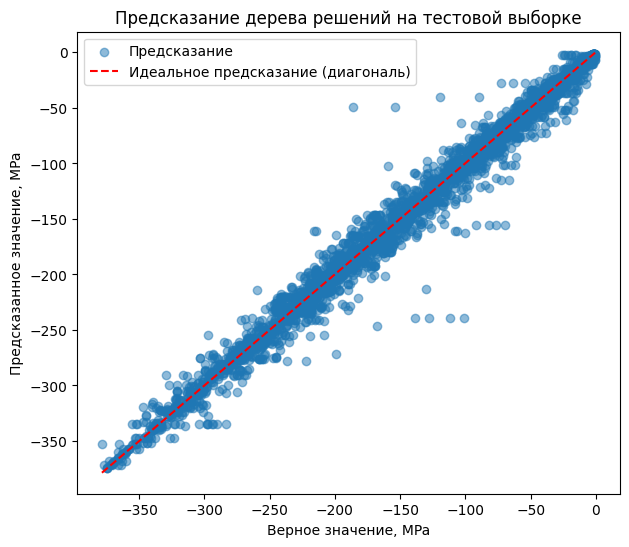

In [12]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred_best, alpha=0.5, label="Предсказание")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Идеальное предсказание (диагональ)",
)
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значение, MPa")
plt.title("Предсказание дерева решений на тестовой выборке")
plt.legend()
plt.savefig(f"best_decision_tree_prediction_{component_num}.png", dpi=400)
plt.show()


## Анализ важности признаков

Анализ важности признаков позволяет определить, какие входные параметры оказывают наибольшее влияние на прогнозирование модели дерева решений.

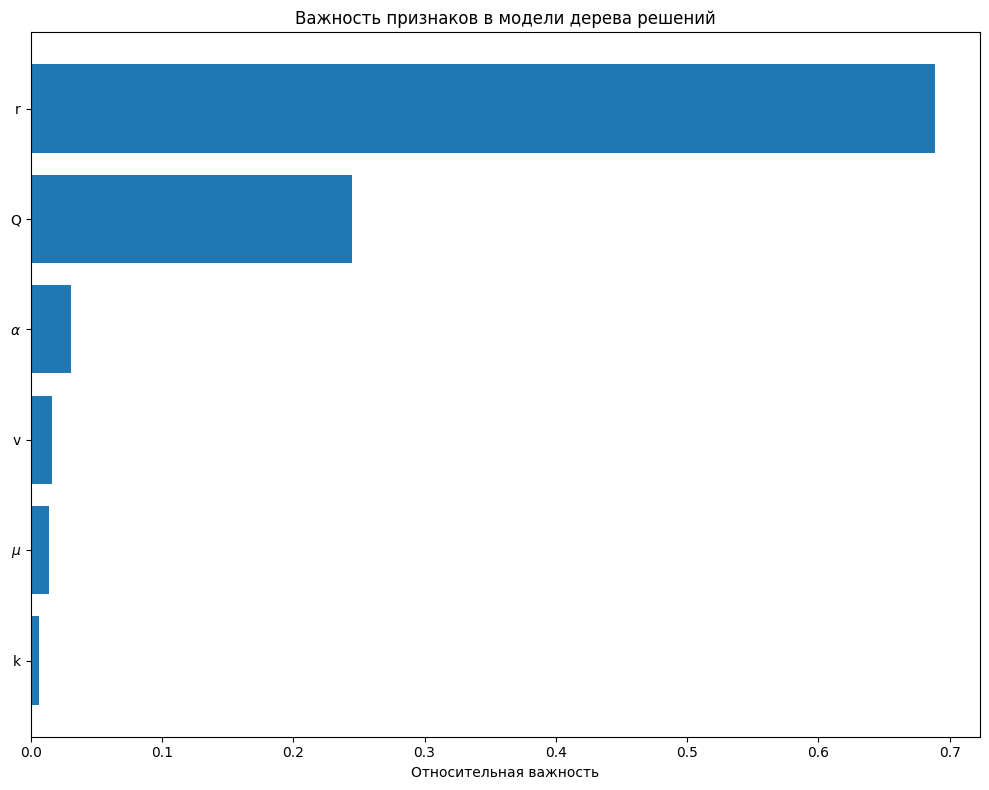

Важность признаков (топ-5):
$\mu$: 0.0136
v: 0.0160
$\alpha$: 0.0308
Q: 0.2450
r: 0.6886


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Получение важности признаков из модели
importance = best_model.feature_importances_

# Если есть имена признаков, можно использовать их
feature_names = ["Q", "k", "$\\alpha$", "$\mu$", "v", "r"]

# Сортировка признаков по важности
indices = np.argsort(importance)

# Создание визуализации
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Относительная важность')
plt.title('Важность признаков в модели дерева решений')
plt.tight_layout()
plt.savefig(f'feature_importance_decision_tree_{component_num}.png', dpi=400)
plt.show()

# Вывод числовых значений важности
print("Важность признаков (топ-5):")
for i in indices[-5:]:
    print(f"{feature_names[i]}: {importance[i]:.4f}")

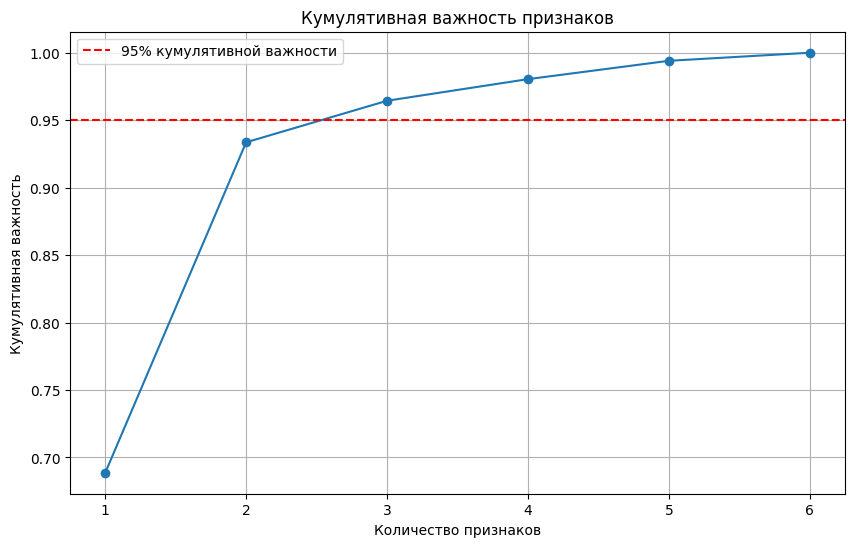

Количество признаков, объясняющих 95% важности: 3 из 6


In [15]:
# Кумулятивный анализ важности признаков
sorted_importances = np.sort(importance)[::-1]
cumulative_importance = np.cumsum(sorted_importances)

# Создание визуализации кумулятивной важности
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% кумулятивной важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True)
plt.savefig(f'cumulative_importance_decision_tree_{component_num}.png', dpi=400)
plt.show()

# Определение количества признаков, объясняющих 95% дисперсии
features_95 = np.where(cumulative_importance >= 0.95)[0][0] + 1
print(f"Количество признаков, объясняющих 95% важности: {features_95} из {len(importance)}")

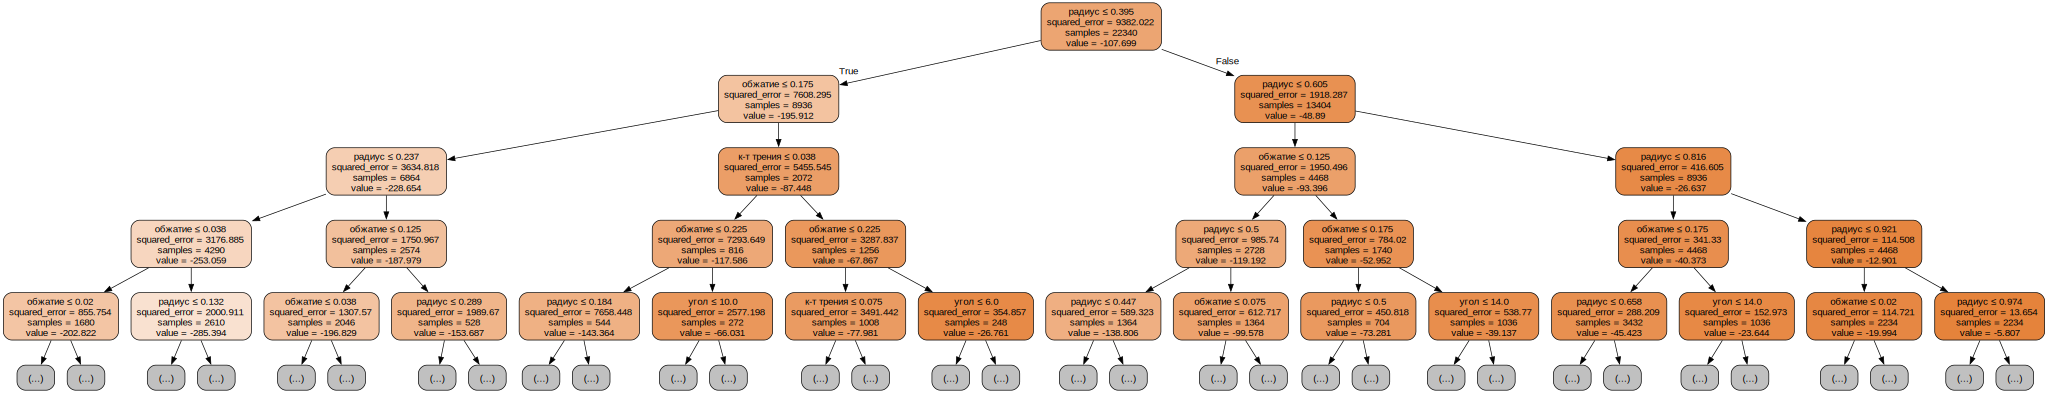

Визуализация структуры дерева сохранена в файл decision_tree_structure_2.png


In [16]:
# Визуализация структуры дерева
from sklearn import tree
import graphviz

# Создание визуализации дерева (ограничим глубину отображения для наглядности)
max_depth_to_display = min(4, best_params["max_depth"])

# Экспорт дерева в формате DOT
dot_data = tree.export_graphviz(
    best_model,
    max_depth=max_depth_to_display,
    out_file=None,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    special_characters=True
)

# Попытка отобразить дерево с помощью graphviz
try:
    graph = graphviz.Source(dot_data)
    # Сохраняем изображение дерева в файл
    graph.render(f"decision_tree_structure_{component_num}", format="png", cleanup=True)
    display(graph)
    print(f"Визуализация структуры дерева сохранена в файл decision_tree_structure_{component_num}.png")
except Exception as e:
    print(f"Не удалось отобразить структуру дерева: {e}")
    print("Для визуализации дерева установите graphviz: pip install graphviz и библиотеку graphviz для вашей ОС")

Расчет permutation importance (может занять некоторое время)...
Время выполнения: 4.46 секунд
Время выполнения: 4.46 секунд


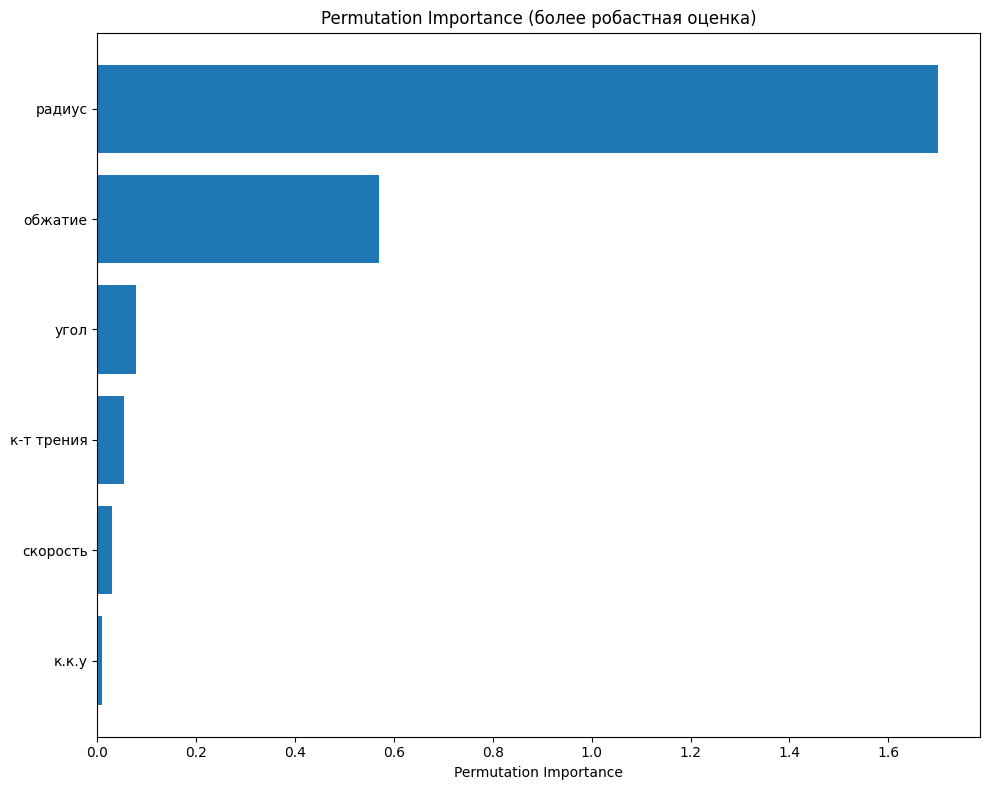

Сравнение методов оценки важности признаков (топ-10):
   Признак  Важность (MDI)  Важность (Permutation)
    радиус        0.688642                1.700541
   обжатие        0.244961                0.569781
      угол        0.030800                0.077427
к-т трения        0.013589                0.053808
  скорость        0.016017                0.028602
     к.к.у        0.005991                0.009529


In [17]:
# Анализ важности признаков с помощью permutation importance
from sklearn.inspection import permutation_importance
import time

print("Расчет permutation importance (может занять некоторое время)...")
start_time = time.time()

# Выполнение permutation importance на тестовых данных
r_perm = permutation_importance(best_model, cur_X_test, cur_y_test, 
                             n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Сортировка результатов
perm_sorted_idx = r_perm.importances_mean.argsort()

# Визуализация permutation importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(perm_sorted_idx)), r_perm.importances_mean[perm_sorted_idx])
plt.yticks(range(len(perm_sorted_idx)), [feature_names[i] for i in perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance (более робастная оценка)')
plt.tight_layout()
plt.savefig(f'permutation_importance_decision_tree_{component_num}.png', dpi=400)
plt.show()

# Сравнение с исходной важностью признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (MDI)': importance,
    'Важность (Permutation)': r_perm.importances_mean
})

importance_df = importance_df.sort_values('Важность (Permutation)', ascending=False)
print("Сравнение методов оценки важности признаков (топ-10):")
print(importance_df.head(10).to_string(index=False))